In [25]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Make NumPy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

In [26]:
raw_dataset = pd.read_csv(os.path.join("data", "flight_data_processed.csv"))
raw_dataset["zone"] = raw_dataset["zone"].apply(lambda x: True if x == "thermal" else False)
raw_dataset = raw_dataset[["gps_altitude_m","speed_km/s","climb_m","climb_m(delta)","climb_rate_m/s","bearing","delta_bearing","glide_ratio","elapsed_time","temp","pressure","humidity","dew_point","wind_speed","wind_deg", "zone"]]
dataset = raw_dataset.copy()
dataset.head()

/var/folders/ss/5qhyykzn7ws047pz5bmmgw1r0000gn/T/ipykernel_4795/2147613681.py:1: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  raw_dataset = pd.read_csv(os.path.join("data", "flight_data_processed.csv"))


,gps_altitude_m,speed_km/s,climb_m,climb_m(delta),climb_rate_m/s,bearing,delta_bearing,glide_ratio,elapsed_time,temp,pressure,humidity,dew_point,wind_speed,wind_deg,zone
0,1115,12.218615,0.0,-3.0,0.0,303,67.0,0.000000,0.0,26.69,1010.0,37.0,10.81,3.38,306.0,False
1,1115,25.606488,0.0,-3.0,0.0,270,33.0,0.000000,1.0,26.69,1010.0,37.0,10.81,3.38,306.0,False
2,1115,20.485190,0.0,-3.0,0.0,270,0.0,0.000000,2.0,26.69,1010.0,37.0,10.81,3.38,306.0,False
3,1116,25.606488,1.0,-2.0,1.0,270,0.0,7.112913,3.0,26.69,1010.0,37.0,10.81,3.38,306.0,True
4,1117,21.541278,1.0,-1.0,1.0,288,18.0,5.983688,4.0,26.69,1010.0,37.0,10.81,3.38,306.0,True


In [27]:
dataset.describe()

,gps_altitude_m,speed_km/s,climb_m,climb_m(delta),climb_rate_m/s,bearing,delta_bearing,glide_ratio,elapsed_time,temp,pressure,humidity,dew_point,wind_speed,wind_deg
count,173943.000000,173943.000000,173943.000000,173943.000000,173943.000000,173943.000000,173943.000000,173943.000000,173943.000000,173943.000000,173943.000000,173943.000000,173943.000000,173943.000000,173943.000000
mean,2549.013677,52.049776,-0.031964,-0.632339,-0.026192,128.208505,11.336541,8.336186,16822.956221,31.048488,1006.838010,30.089995,10.966365,3.138136,229.898335
std,621.275795,25.169579,2.587599,44.476908,1.869562,93.148811,17.172823,8.480289,9743.969272,2.945894,2.086364,7.442854,2.804663,1.262021,100.911881
min,376.000000,0.000000,-30.000000,-383.000000,-11.000000,0.000000,0.000000,0.000000,0.000000,24.160000,1003.000000,14.000000,3.190000,0.500000,0.000000
25%,2160.000000,41.296352,-1.000000,-26.000000,-1.000000,47.000000,2.000000,3.082997,8427.000000,28.920000,1005.000000,23.000000,9.700000,2.020000,202.000000
50%,2551.000000,53.539497,0.000000,-1.000000,0.000000,122.000000,6.000000,7.368595,16791.000000,30.610000,1007.000000,33.000000,11.250000,3.370000,234.000000
75%,2937.000000,63.605984,1.000000,23.000000,1.000000,184.000000,14.000000,12.795062,25154.000000,33.810000,1008.000000,36.000000,13.010000,4.220000,316.000000
max,4403.000000,4788.987450,44.000000,1222.000000,44.000000,358.000000,180.000000,1306.481640,36656.000000,37.130000,1015.000000,42.000000,17.500000,5.510000,358.000000


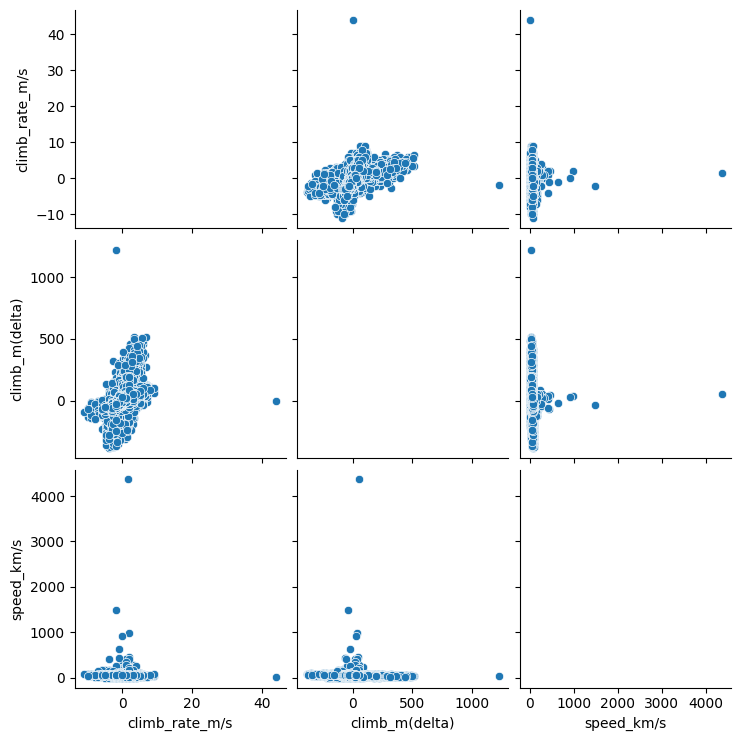

In [28]:
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

sns.pairplot(train_dataset[["climb_rate_m/s", "climb_m(delta)", "speed_km/s"]], diag_kind="zone")

Let's also check the overall statistics. Note how each feature covers a very different range:

In [29]:
train_dataset.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
gps_altitude_m,139154.0,2548.626780,621.342319,376.00,2160.000000,2551.000000,2937.000000,4403.000000
speed_km/s,139154.0,51.973147,21.246772,0.00,41.289233,53.539357,63.600100,4361.850992
climb_m,139154.0,-0.034271,2.580568,-30.00,-1.000000,0.000000,1.000000,44.000000
climb_m(delta),139154.0,-0.638868,44.534428,-383.00,-26.000000,-1.000000,23.000000,1222.000000
climb_rate_m/s,139154.0,-0.025410,1.870311,-11.00,-1.000000,0.000000,1.000000,44.000000
bearing,139154.0,128.165859,93.077509,0.00,47.000000,122.000000,184.000000,358.000000
delta_bearing,139154.0,11.323893,17.113174,0.00,2.000000,6.000000,14.000000,180.000000
glide_ratio,139154.0,8.313781,7.821970,0.00,3.082997,7.353455,12.762419,807.750184
elapsed_time,139154.0,16836.620924,9751.289315,0.00,8417.000000,16821.500000,25155.000000,36656.000000
temp,139154.0,31.049846,2.948625,24.16,28.920000,30.610000,33.810000,37.130000


In [30]:
train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop("zone")
test_labels = test_features.pop("zone")

train_dataset.describe().transpose()[['mean', 'std']]

,mean,std
gps_altitude_m,2548.626780,621.342319
speed_km/s,51.973147,21.246772
climb_m,-0.034271,2.580568
climb_m(delta),-0.638868,44.534428
climb_rate_m/s,-0.025410,1.870311
bearing,128.165859,93.077509
delta_bearing,11.323893,17.113174
glide_ratio,8.313781,7.821970
elapsed_time,16836.620924,9751.289315
temp,31.049846,2.948625


In [31]:
normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(np.array(train_features))
print(normalizer.mean.numpy())

[[ 2548.627    51.973    -0.034    -0.639    -0.025   128.166    11.324
      8.314 16836.621    31.05   1006.836    30.078    10.96      3.139
    229.927]]


In [32]:
first = np.array(train_features[:1])

with np.printoptions(precision=2, suppress=True):
  print('First example:', first)
  print()
  print('Normalized:', normalizer(first).numpy())

First example: [[ 2300.      77.76    -3.     -41.      -3.     160.       0.       7.2
  12410.      29.88  1008.      41.      15.21     3.5    340.  ]]

Normalized: [[-0.4   1.21 -1.15 -0.91 -1.59  0.34 -0.66 -0.14 -0.45 -0.4   0.56  1.47
   1.51  0.29  1.09]]


In [33]:
vario = np.array(train_features["climb_rate_m/s"])

vario_normalizer = layers.Normalization(input_shape=[1,], axis=None)
vario_normalizer.adapt(vario)
vario_model = tf.keras.Sequential([
    vario_normalizer,
    layers.Dense(units=1)
])

vario_model.summary()

/Users/serkan/Documents/Paragliding_Flight_Analyses/.venv/lib/python3.11/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization_3 (Normalization) │ (None, 1)              │             3 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │             2 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5 (24.00 B)

 Trainable params: 2 (8.00 B)

 Non-trainable params: 3 (16.00 B)

In [34]:
vario_model.predict(vario[:10])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


array([[-1.438],
       [-0.471],
       [ 1.947],
       [ 2.914],
       [-1.438],
       [ 0.012],
       [-0.955],
       [-0.955],
       [ 0.979],
       [-1.438]], dtype=float32)

In [35]:
vario_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')

In [36]:
%%time
history = vario_model.fit(
    train_features["climb_rate_m/s"],
    train_labels,
    epochs=10,
    # Suppress logging.
    verbose=0,
    # Calculate validation results on 20% of the training data.
    validation_split = 0.2)

hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

CPU times: user 14.8 s, sys: 2.41 s, total: 17.2 s
Wall time: 12 s


,loss,val_loss,epoch
5,0.287319,0.292467,5
6,0.287627,0.285910,6
7,0.287269,0.280061,7
8,0.286501,0.286408,8
9,0.287285,0.282541,9


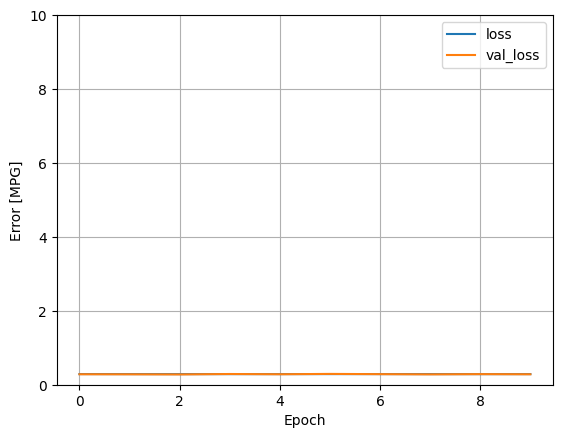

In [37]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 10])
  plt.xlabel('Epoch')
  plt.ylabel('Error [MPG]')
  plt.legend()
  plt.grid(True)
  
plot_loss(history)

Collect the results on the test set for later:

In [38]:
test_results = {}

test_results['vario_model'] = vario_model.evaluate(
    test_features['climb_rate_m/s'],
    test_labels, verbose=0)

In [39]:
x = tf.linspace(0.0, 250, 251)
y = vario_model.predict(x)

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


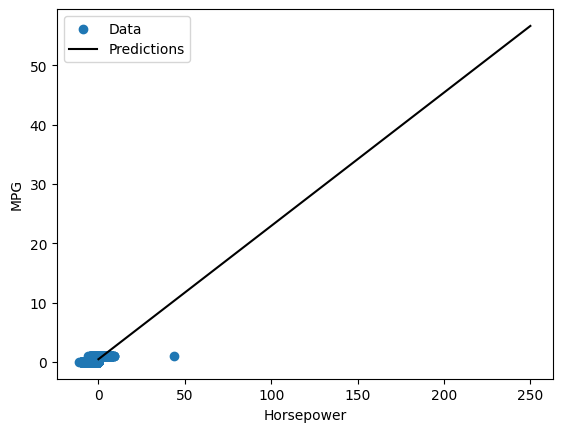

In [40]:
def plot_vario(x, y):
  plt.scatter(train_features['climb_rate_m/s'], train_labels, label='Data')
  plt.plot(x, y, color='k', label='Predictions')
  plt.xlabel('Horsepower')
  plt.ylabel('MPG')
  plt.legend()

plot_vario(x, y)

In [41]:
linear_model = tf.keras.Sequential([
    normalizer,
    layers.Dense(units=1)
])

In [42]:
linear_model.predict(train_features[:10])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


array([[ 0.041],
       [ 1.447],
       [-1.101],
       [-0.254],
       [-0.017],
       [-0.307],
       [ 0.002],
       [ 1.097],
       [ 0.032],
       [-1.001]], dtype=float32)

In [43]:
linear_model.layers[1].kernel

<Variable path=sequential_3/dense_3/kernel, shape=(15, 1), dtype=float32, value=[[ 0.221]
 [-0.591]
 [-0.342]
 [-0.4  ]
 [ 0.593]
 [-0.264]
 [-0.503]
 [ 0.414]
 [-0.239]
 [ 0.11 ]
 [-0.137]
 [ 0.489]
 [-0.101]
 [-0.212]
 [ 0.329]]>

In [44]:
linear_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')

In [45]:
%%time
history = linear_model.fit(
    train_features,
    train_labels,
    epochs=10,
    # Suppress logging.
    verbose=0,
    # Calculate validation results on 20% of the training data.
    validation_split = 0.2)

CPU times: user 15.2 s, sys: 2.44 s, total: 17.6 s
Wall time: 12.3 s


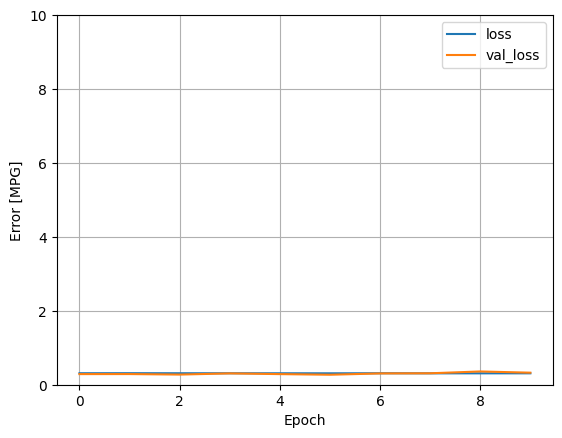

In [46]:
plot_loss(history)

In [47]:
test_results['linear_model'] = linear_model.evaluate(
    test_features, test_labels, verbose=0)

In [48]:
def build_and_compile_model(norm):
  model = keras.Sequential([
      norm,
      layers.Dense(64, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(1)
  ])

  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
  return model

In [49]:
dnn_vario_model = build_and_compile_model(vario_normalizer)

In [50]:
dnn_vario_model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization_3 (Normalization) │ (None, 1)              │             3 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,356 (17.02 KB)

 Trainable params: 4,353 (17.00 KB)

 Non-trainable params: 3 (16.00 B)

Train the model with Keras `Model.fit`:

In [52]:
%%time
history = dnn_vario_model.fit(
    train_features['climb_rate_m/s'],
    train_labels,
    validation_split=0.2,
    verbose=0, epochs=10)

CPU times: user 17.2 s, sys: 2.32 s, total: 19.5 s
Wall time: 13.8 s


This model does slightly better than the linear single-input `horsepower_model`:

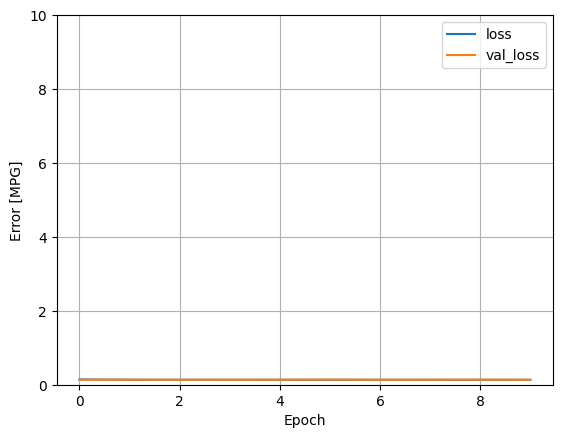

In [53]:
plot_loss(history)

If you plot the predictions as a function of `'Horsepower'`, you should notice how this model takes advantage of the nonlinearity provided by the hidden layers:

In [54]:
x = tf.linspace(0.0, 250, 251)
y = dnn_vario_model.predict(x)

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


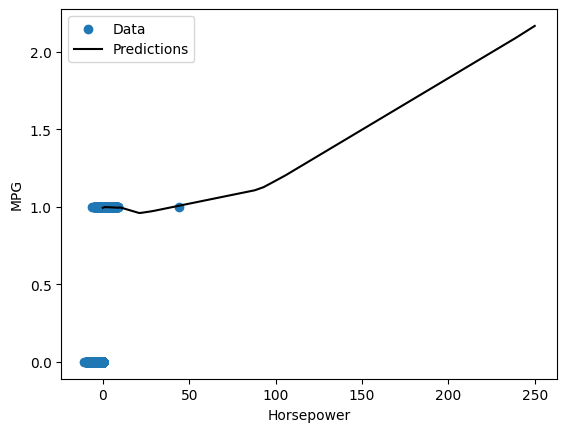

In [55]:
plot_vario(x, y)

Collect the results on the test set for later:

In [57]:
test_results['dnn_vario_model'] = dnn_vario_model.evaluate(
    test_features['climb_rate_m/s'], test_labels,
    verbose=0)

In [58]:
dnn_model = build_and_compile_model(normalizer)
dnn_model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization_2 (Normalization) │ (10, 15)               │            31 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31 (128.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 31 (128.00 B)

In [59]:
%%time
history = dnn_model.fit(
    train_features,
    train_labels,
    validation_split=0.2,
    verbose=0, epochs=10)

CPU times: user 17.6 s, sys: 2.38 s, total: 20 s
Wall time: 14.4 s


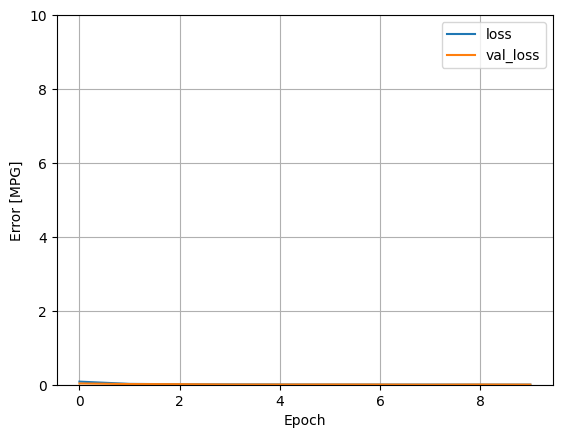

In [60]:
plot_loss(history)

In [61]:
test_results['dnn_model'] = dnn_model.evaluate(test_features, test_labels, verbose=0)

In [62]:
pd.DataFrame(test_results, index=['Mean absolute error [MPG]']).T

,Mean absolute error [MPG]
vario_model,0.284044
linear_model,0.327001
dnn_vario_model,0.134527
dnn_model,0.002509


1088/1088 ━━━━━━━━━━━━━━━━━━━━ 0s 224us/step


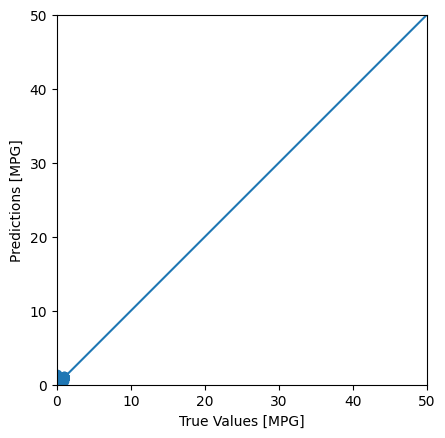

In [63]:
test_predictions = dnn_model.predict(test_features).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
lims = [0, 50]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)


It appears that the model predicts reasonably well.

Now, check the error distribution:

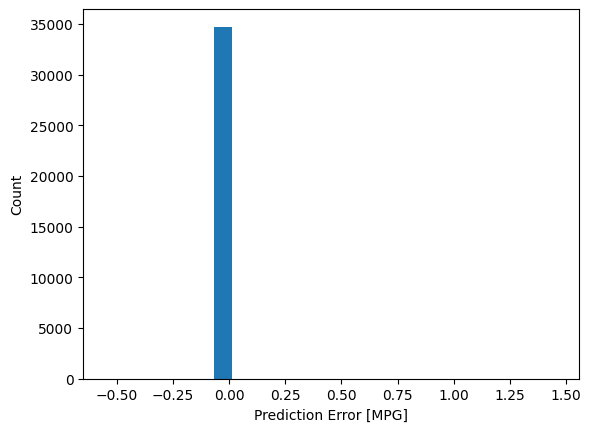

In [64]:
error = test_predictions - test_labels
plt.hist(error, bins=25)
plt.xlabel('Prediction Error [MPG]')
_ = plt.ylabel('Count')

If you're happy with the model, save it for later use with `Model.save`:

In [65]:
dnn_model.save('dnn_model.keras')

In [66]:
reloaded = tf.keras.models.load_model('dnn_model.keras')

test_results['reloaded'] = reloaded.evaluate(
    test_features, test_labels, verbose=0)

In [67]:
pd.DataFrame(test_results, index=['Mean absolute error [MPG]']).T

,Mean absolute error [MPG]
vario_model,0.284044
linear_model,0.327001
dnn_vario_model,0.134527
dnn_model,0.002509
reloaded,0.002509
